In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
import math
from scipy.stats.distributions import norm
from scipy.stats import gamma
import sobol_seq
import ghalton
from scipy import stats
from pyDOE import *
%matplotlib inline

In [2]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    #Solves the diffusion equation with Generalized Source
    A = sparse.dia_matrix((Nx,Nx),dtype="complex")
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx + kappa)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    #solve A x = Source
    Solution = linalg.spsolve(A.tocsr(),Source)
    Q = integrate.trapz(Solution*kappa,dx=dx)
    return Solution, Q

[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]
(53.3044702688+0j)


/Users/ryanmcclarren/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


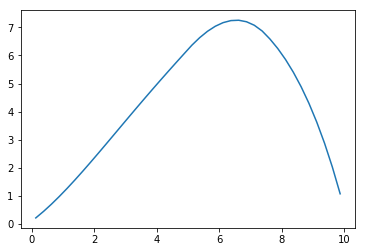

In [3]:
Lx = 10
Nx = 40
dx = Lx/Nx
Source_func = lambda x, q:  q*x*(10-x)
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>5)*(x<7.5)
v_func = lambda x,v: v*np.ones(x.size)
omega_func = lambda x,omega: omega*np.ones(x.size)

#nominal values

import csv

xs = np.linspace(dx/2,Lx-dx/2,Nx)
source = Source_func(xs, 1)
kappa = kappa_func(xs, 0.1, 2)

omega_nom = 20
omega_var = 0.3195214
v_nom = 10
v_var = 0.0723493
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
vs = v_func(xs, v_nom)
print(vs)
sol,Q = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs, kappa)
print(Q)
plt.plot(xs,sol)
plt.show()

In [5]:
mean_kappa = kappa_func(xs, kappal_nom, kappah_nom)
exp_cov = lambda x,y: 0.025*np.exp(-0.1*np.abs(x-y))
kappa_cov = np.zeros((xs.size,xs.size))
for i in range(xs.size):
    for j in range(xs.size):
        kappa_cov[i,j] = exp_cov(dx*i,dx*j)
chol = np.linalg.cholesky(kappa_cov)
sol,Q = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), v_func(xs, v_nom), mean_kappa)
print(Q)

(53.3044702688+0j)


In [6]:
def gen_samps(samps,test,chol,mean_kappa):
    Qs = np.zeros(samps)
    for n in range(samps):
        #generate samples
        kappa1 = mean_kappa + np.dot(chol,test[n,:])
        sol,Qs[n] = ADRSource(Lx, Nx, Source_func(xs, q_nom), omega_func(xs, omega_nom), v_func(xs, v_nom), kappa1)

    #plt.plot(kappa1)
    return Qs

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


53.1810498325 19.1555392198


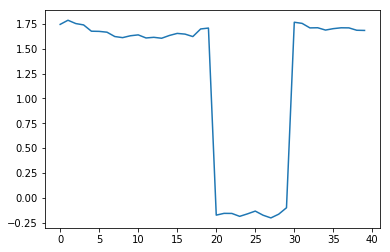

In [7]:
#test srs
samps = 1000
tests = np.zeros((samps,Nx))
for i in range(samps):
    tests[i,:] = np.random.normal(size=Nx)
#print(tests[0,:])
#print(np.dot(chol,np.transpose(tests[0,:])))
QSRS=gen_samps(samps,tests,chol,mean_kappa)
print(np.mean(QSRS[:,1]), np.var(QSRS[:,1]))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


53.1431131833 18.9064301955


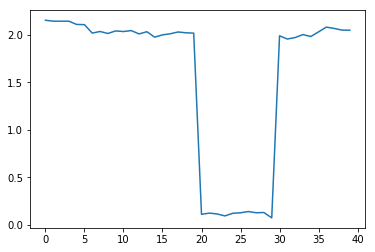

In [8]:
#test LHS
lhd = lhs(Nx, samples=samps)
test_lhs = norm.ppf(lhd)
QLHS=gen_samps(samps,test_lhs,chol,mean_kappa)
print(np.mean(QLHS[:,1]), np.var(QLHS[:,1]))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


53.1640220536 17.065946587


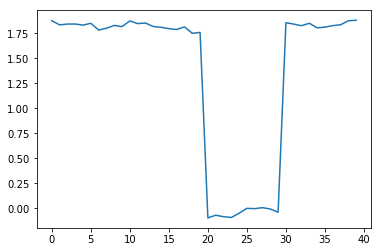

In [9]:
#test Sobol
skip = round(np.log(samps)/np.log(2))
sobol_qmc = sobol_seq.i4_sobol_generate(Nx,samps, skip = 2**skip)
test_sobol = norm.ppf(sobol_qmc)
Qsobol=gen_samps(samps,test_sobol,chol,mean_kappa)
print(np.mean(Qsobol[:,1]), np.var(Qsobol[:,1]))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


52.400062012 21.9604010111


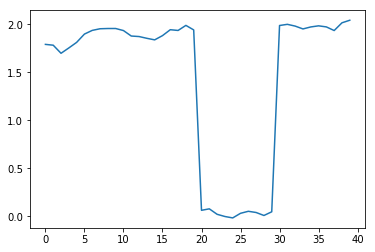

In [10]:
#test halton
halton_des = (np.array(ghalton.Halton(Nx).get(samps)))
test_halton = norm.ppf(halton_des)
Qhalton=gen_samps(samps,test_halton,chol,mean_kappa)
print(np.mean(Qhalton[:,1]), np.var(Qhalton[:,1]))

In [17]:
Nsamps = [100,400,800,1000,10**4,10**5] #
count = 0
for samps in Nsamps:
    #SRS
    tests = np.zeros((samps,Nx))
    for i in range(samps):
        tests[i,:] = np.random.normal(size=Nx)
    QSRS=gen_samps(samps,tests,chol,mean_kappa)
    np.savetxt(fname="proc_srs_"+ str(samps) + ".csv", delimiter=",", 
               X=QSRS)
    
    # LHS
    lhd = lhs(Nx, samples=samps)
    test_lhs = norm.ppf(lhd)
    QLHS=gen_samps(samps,test_lhs,chol,mean_kappa)
    np.savetxt(fname="proc_lhs_"+ str(samps) + ".csv", delimiter=",", 
               X=QLHS)
    # Sobol
    skip = round(np.log(samps)/np.log(2))
    sobol_qmc = sobol_seq.i4_sobol_generate(Nx,samps, skip = 2**skip)
    test_sobol = norm.ppf(sobol_qmc)
    Qsobol=gen_samps(samps,test_sobol,chol,mean_kappa)
    np.savetxt(fname="proc_sobol_"+ str(samps) + ".csv", delimiter=",", 
               X=Qsobol)
    # halton
    halton_des = (np.array(ghalton.Halton(Nx).get(samps)))
    test_halton = norm.ppf(halton_des)
    Qhalton=gen_samps(samps,test_halton,chol,mean_kappa)
    np.savetxt(fname="proc_halton_"+ str(samps) + ".csv", delimiter=",", 
               X=Qhalton)


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [7]:
# LHS
samps = 10**7
lhd = lhs(Nx, samples=samps)
test_lhs = norm.ppf(lhd)
QLHS=gen_samps(samps,test_lhs,chol,mean_kappa)
np.savetxt(fname="proc_ref_"+ str(samps) + ".csv", delimiter=",", 
           X=QLHS)

/Users/ryanmcclarren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [ ]:
# SRS
samps = 10**7
tests = np.zeros((samps,Nx))
for i in range(samps):
    tests[i,:] = np.random.normal(size=Nx)
QSRS=gen_samps(samps,tests,chol,mean_kappa)
np.savetxt(fname="proc_ref_srs_"+ str(samps) + ".csv", delimiter=",", 
           X=QSRS)

/Users/ryanmcclarren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
